In [8]:
import pickle

from scipy.stats import norm
from scipy.stats import iqr

import numpy as np
import pymc3 as pm
import theano.tensor as tt
import pymbar

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [9]:
SEED = 2039
SIZE = 50

SMC_STEPS = 20000
MET_STEPS = 20000

# Data Generation

In [10]:
def gaussian_mixture(mu1=0, sigma1=1, mu2=0, sigma2=1,
                     rho=0.5,
                     size=100, random_state=None):
    rnd = np.random.RandomState(random_state)
    x = []
    for _ in range(size):
        if rnd.rand() < rho:
            x.append(rnd.normal(loc=mu1, scale=sigma1))
        else:
            x.append(rnd.normal(loc=mu2, scale=sigma2))
    return np.array(x)

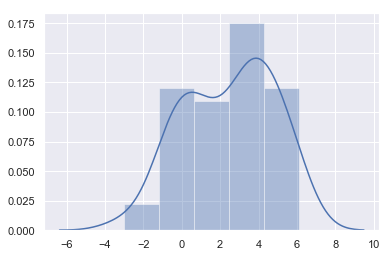

In [11]:
x = gaussian_mixture(mu1=0, sigma1=1, mu2=4, sigma2=1, rho=0.5, size=SIZE, random_state=SEED)
sns.distplot(x)

# Models

## Model 1

In [12]:
with pm.Model() as model_m1:
    mu = pm.Uniform("mu", lower=-10, upper=10)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=x)

print(model_m1.vars)

[mu_interval__]


## Model 2

In [14]:
with pm.Model() as model_2:
    w = pm.floatX([.5, .5])
    sigmas = pm.floatX([1., 1])
    
    mu1 = pm.Uniform("mu1", lower=-10, upper=10)
    dmu = pm.Uniform("dmu", lower=0, upper=10)
    means = tt.zeros([2])
    means = tt.set_subtensor(means[0], mu1)
    means = tt.set_subtensor(means[1], mu1 + dmu)
    
    obs = pm.NormalMixture("obs", w=w, mu=means, sigma=sigmas, observed=x)

print(model_2.vars)

[mu1_interval__, dmu_interval__]


# Sequential Monte Carlo

In [15]:
def bayes_factor_smc(model_ini, model_fin):
    log_bf = np.log10(model_fin.marginal_likelihood) - np.log10(model_ini.marginal_likelihood)
    return log_bf